# 机器学习练习 6 - 支持向量机

__在SVM中其实有很多的公式，以及在课上吴老师对其工作原理也做了比较深入的讲解，建议复习回顾一下再来看作业。__

本次练习，我们的任务是使用高斯核函数的支持向量机（SVM）来构建垃圾邮件分类器。

 我们将从一些简单的2D数据集开始使用SVM来查看它们的工作原理。 然后，我们将对一组原始电子邮件进行一些预处理工作，并使用SVM电子邮件上构建分类器，以确定它们是否为垃圾邮件。

##  支持向量

我们先在2D数据上看一下SVM的运行，并尝试使用不同的C，看会产生怎样的影响 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
raw_data = loadmat('data/ex6data1.mat')
data = pd.DataFrame( raw_data.get('X') , columns=['X1' , 'X2'])
data['y'] = raw_data.get('y')
data.head()


,X1,X2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


### 数据可视化

In [3]:
def plot_init_data( data , fig , ax ): 
    positive = data[ data['y'].isin([1]) ]
    negayive = data[ data['y'].isin([0]) ]
    
    ax.scatter( positive['X1'] , positive['X2'] , s=50 , marker='x' , label='Posotive' )
    ax.scatter( negayive['X1'] , negayive['X2'] , s=50 , marker='o' , label='Negative' )
    
    
    

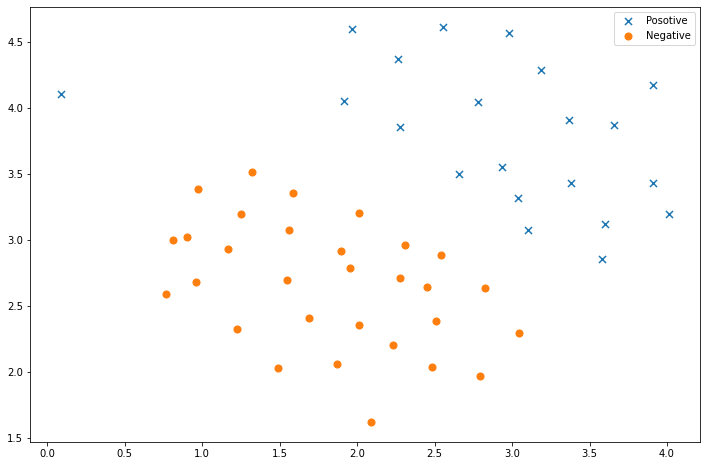

In [4]:
fig , ax = plt.subplots(figsize = (12,8))
plot_init_data(data , fig , ax)
ax.legend()
plt.show()

存在异常点

令C = 1

In [5]:
from sklearn import svm

svc = svm.LinearSVC(C=1 , loss='hinge' , max_iter=1000)
svc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [6]:
svc.fit( data[['X1' ,'X2']] , data['y'] )
svc.score( data[['X1' , 'X2']] , data['y'] )


/Users/chenchangming/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/base.py:928: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9803921568627451

###  可视化分类边界

In [7]:
def find_decision_boundary( svc , x1min , x1max , x2min , x2max , diff ): 
    x1 = np.linspace(x1min , x1max , 1000)
    x2 = np.linspace(x2min , x2max , 1000)
    
    cordinates =[ (x,y) for x in x1  for y in x2 ]
    x_cord , y_cord = zip(*cordinates)
    c_val = pd.DataFrame( {'x1':x_cord , 'x2':y_cord} )
    c_val['cval'] = svc.decision_function( c_val[ ['x1','x2'] ] )
    
    decision = c_val[ np.abs( c_val['cval'] ) < diff ]
    
    return decision.x1 , decision.x2
    
    

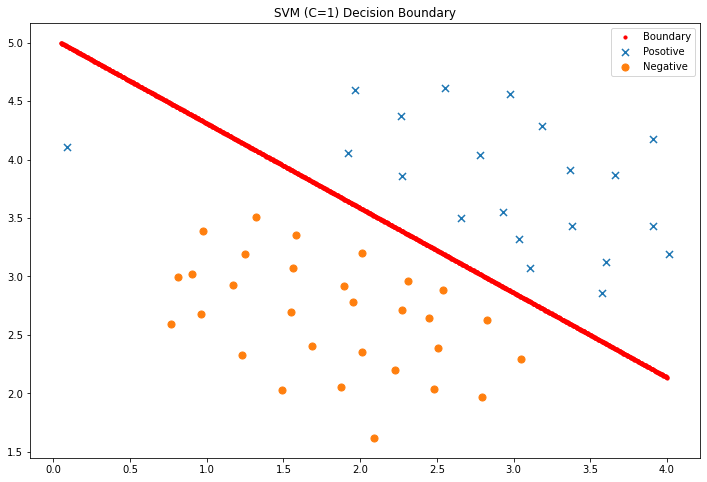

In [8]:
x1 , x2 = find_decision_boundary(svc , 0 , 4 , 1.5 , 5 , 2 * 10**-3)
fig , ax = plt.subplots( figsize=(12,8) )
ax.scatter(x1 , x2 ,  s=10 , c='r' ,  label='Boundary')
plot_init_data(data , fig , ax)
ax.set_title('SVM (C=1) Decision Boundary')
ax.legend()
plt.show()

增大C=1 -> C=100

In [9]:
svc2 = svm.LinearSVC(C=100,loss='hinge' , max_iter=1000)
svc2.fit(data[ [ 'X1','X2' ] ] , data['y'])
svc2.score( data[ ['X1' , 'X2'] ] , data['y'] )


/Users/chenchangming/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/base.py:928: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9411764705882353

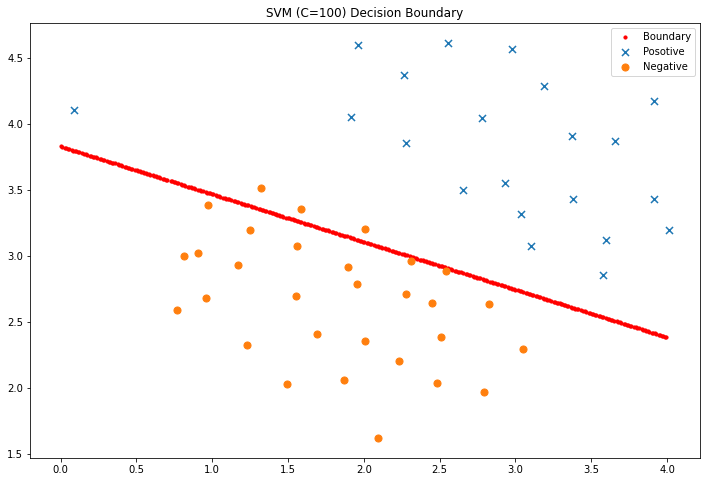

In [10]:
x1 , x2 = find_decision_boundary(svc2 , 0 , 4 , 1.5 , 5 , 2 * 10**-3)
fig , ax = plt.subplots( figsize=(12,8) )
ax.scatter(x1,x2,s=10,c='r',label='Boundary')
plot_init_data(data , fig , ax)
ax.set_title('SVM (C=100) Decision Boundary')
ax.legend()
plt.show()

得到的边界不再适合决策

### 高斯内核的SVM

转入非线性SVM，需要我们实现一个高斯核函数

###  高斯内核

'距离' 函数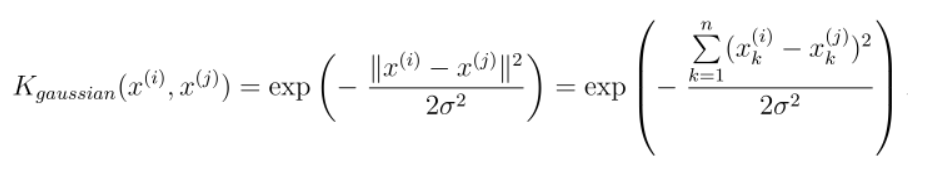

In [11]:
def gaussian_kernal(x1 , x2 , sigma): 
    return np.exp( -np.sum( (x1-x2)**2/( 2*(sigma**2) )  ) )

In [12]:
x1 = np.array( [1.0 , 2.0 , 1.0] )
x2 = np.array( [0.0 , 4.0 , -1.0 ] )
sigma = 2
gaussian_kernal(x1 , x2 , sigma)

0.32465246735834974

下面换另一个数据集，并使用非线性决策边界

###  数据集2

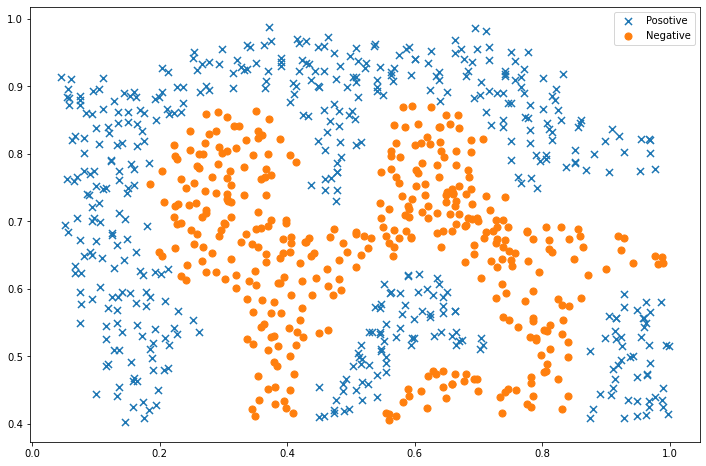

In [13]:
raw_data = loadmat('data/ex6data2.mat')

data = pd.DataFrame( raw_data['X'] , columns=['X1' , 'X2'] )
data['y'] = raw_data['y']

fig , ax = plt.subplots( figsize=(12,8) )
plot_init_data(data , fig , ax)
ax.legend()
plt.show()


可以看出，边界不是线性的

In [14]:
svc = svm.SVC(C=100 , gamma=10 , probability=True)
svc


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [15]:
svc.fit(data[ ['X1' , 'X2'] ] , data['y'])
svc.score( data[ ['X1' , 'X2'] ] , data['y'] )


0.9698725376593279

可视化边界

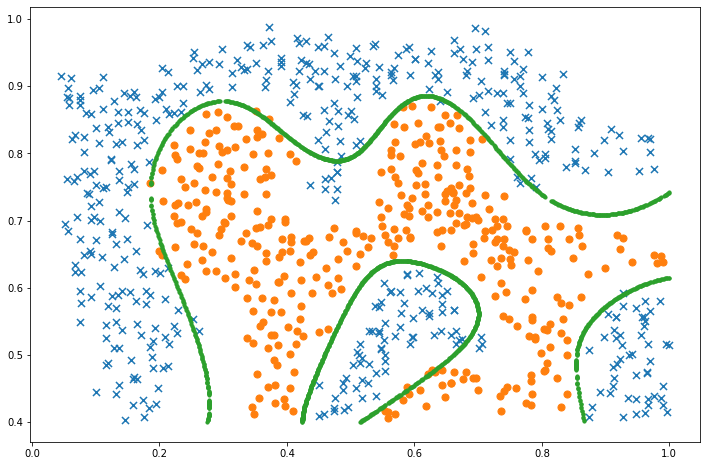

In [16]:
x1 , x2 = find_decision_boundary(svc , 0 , 1 , 0.4 , 1 , 0.01)
fig , ax = plt.subplots( figsize=(12,8) )
plot_init_data(data , fig , ax)
ax.scatter(x1,x2,s=10)
plt.show()

###  数据集3

对于第三个数据集，我们给出了训练和验证集，并且基于验证集性能为SVM模型找到最优超参数。
我们现在需要寻找最优$C$和$\sigma$，候选数值为[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100] 

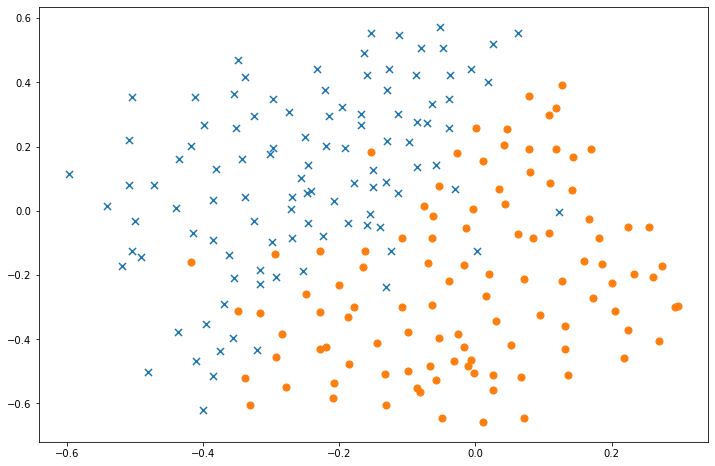

In [17]:
raw_data = loadmat('data/ex6data3.mat')

X = raw_data['X']
Xval = raw_data['Xval']
y = raw_data['y'].ravel()
yval = raw_data['yval'].ravel()

fig , ax = plt.subplots( figsize=(12,8) )
data = pd.DataFrame(raw_data.get('X') , columns=['X1' , 'X2'])
data['y'] = raw_data.get('y')
plot_init_data(data , fig , ax)
plt.show()


找到最优参数

In [18]:
C_values = [0.01 , 0.03 , 0.1 , 0.3 , 1 , 3 , 10 , 30 , 100]
gamms_values = [ 0.01 , 0.03 , 0.1 , 0.3 , 1 , 3 , 10 , 30 , 100 ]

best_score = 0
best_params = { 'C':None , 'gamms':None }

for C in C_values: 
    for gamma in gamms_values: 
        svc = svm.SVC(C=C , gamma=gamma)
        svc.fit(X , y)
        score = svc.score(Xval , yval)
        
        
        if score > best_score: 
            best_score = score
            best_params['C'] = C
            best_params['gamms'] = gamma

best_score , best_params
        


(0.965, {'C': 0.3, 'gamms': 100})

可视化边界

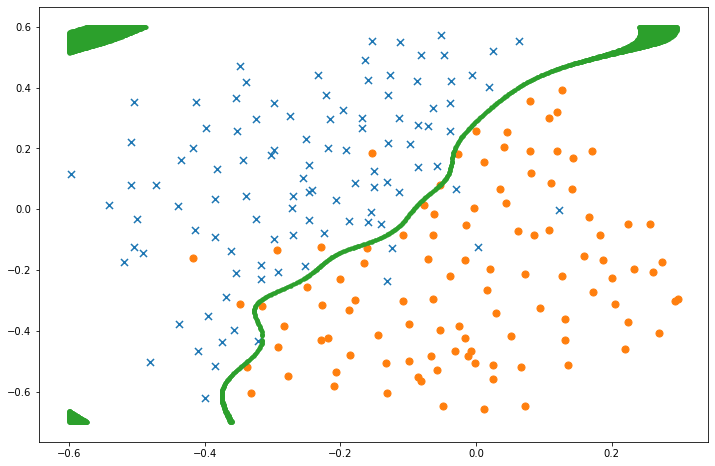

In [19]:
svc = svm.SVC( C=best_params['C'] , gamma=best_params['gamms'] ) 
svc.fit(X,y)

x1 , x2 = find_decision_boundary(svc , -0.6 , 0.3 , -0.7 , 0.6 , 0.005)
fig , ax = plt.subplots( figsize=(12,8) )
plot_init_data(data , fig , ax)
ax.scatter(x1 , x2 , s=10)
plt.show()

## 2 垃圾邮件分类


这2个部分是处理邮件，以获得适合SVM处理的格式的数据。
在练习文本中，有一个任务涉及一些文本预处理，以获得适合SVM处理的格式的数据。  
然而，这个任务很简单（将字词映射到为练习提供的字典中的ID），而其余的预处理步骤（如HTML删除，词干，标准化等）已经完成。
我们就直接读取预先处理好的数据就可以了。

###  训练垃圾邮件分类SVM

In [20]:
spam_train = loadmat('data/spamTrain.mat')
spam_test = loadmat('data/spamTest.mat')

spam_train

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:27:25 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'y': array([[1],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]], dtype=uint8)}

In [21]:
X = spam_train['X']
Xtext = spam_test['Xtest']
y = spam_train['y'].ravel()
ytest = spam_test['ytest'].ravel()

X.shape , y.shape , Xtext.shape , ytest.shape


((4000, 1899), (4000,), (1000, 1899), (1000,))

每个文档已经转换为一个向量，其中1,899个维对应于词汇表中的1,899个单词。 它们的值为二进制，表示文档中是否存在单词。

In [29]:
svc = svm.SVC( C=2, gamma=10)
svc.fit(X , y)


SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
print('Training accuracy = {0}%'.format(np.round(svc.score(X,y)*100 , 2)))

print('Test accuracy = {0}%'.format(np.round(svc.score(Xtext,ytest)*100 , 2)))


Training accuracy = 100.0%
Test accuracy = 79.8%


可以尝试下，使用不同的C  看结果会怎样变化

###  可视化结果

In [31]:
kw = np.eye(1899)
kw[:3,:]
spam_val = pd.DataFrame( {'idx':range(1899)} )

In [32]:
spam_val['isspam'] = svc.decision_function(kw)

In [33]:
kw

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [34]:
spam_val['isspam'].describe()

count    1899.000000
mean       -0.451011
std         0.048770
min        -1.000167
25%        -0.452251
50%        -0.452251
75%        -0.452251
max         0.999833
Name: isspam, dtype: float64

In [35]:
spam_val['isspam']

0      -0.452251
1      -0.452251
2      -0.452251
3      -0.452251
4      -0.452251
          ...   
1894   -0.452251
1895   -0.452251
1896   -0.452251
1897   -0.452251
1898   -0.452251
Name: isspam, Length: 1899, dtype: float64

In [36]:
decision = spam_val[ spam_val['isspam'] > -0.55 ]
decision

,idx,isspam
0,0,-0.452251
1,1,-0.452251
2,2,-0.452251
3,3,-0.452251
4,4,-0.452251
...,...,...
1894,1894,-0.452251
1895,1895,-0.452251
1896,1896,-0.452251
1897,1897,-0.452251


看下对应单词

In [37]:
path = 'data/vocab.txt'
voc = pd.read_csv( path , header=None , names=[ 'idx' , 'voc' ] , sep='\t' )
voc


,idx,voc
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about
...,...,...
1894,1895,your
1895,1896,yourself
1896,1897,zdnet
1897,1898,zero


看下上面测试结果对应的词

In [38]:
spamvoc = voc.loc[ list(decision['idx']) ]
spamvoc

,idx,voc
0,1,aa
1,2,ab
2,3,abil
3,4,abl
4,5,about
...,...,...
1894,1895,your
1895,1896,yourself
1896,1897,zdnet
1897,1898,zero
